In [9]:
import numpy as np

def get_trajectory(npz_file, n=16):
    data = np.load(npz_file)
    print(list(data.keys()))
    hist = data['hist']
    b, t, c, h, w = hist.shape
    return hist[:n, :, :, h//2, w//2]

traj1 = get_trajectory('/data/score_sde_outputs/checkpoint_8/euler_1000/samples_0.npz', n=25)
#traj2 = get_trajectory('/data/score_sde_outputs/checkpoint_8/euler_20/samples_0.npz', n=25)
traj3 = get_trajectory('/data/score_sde_outputs/checkpoint_8/euler_10/samples_0.npz', n=25)
#traj4 = get_trajectory('/data/score_sde_outputs/checkpoint_8/euler_5/samples_0.npz', n=25)
#traj5 = get_trajectory('/data/score_sde_outputs/checkpoint_8/rbf_xt_5/samples_0.npz', n=25)
print('done')

['samples', 'samples_raw', 'prior', 'target', 'hist', 'xt']


['samples', 'samples_raw', 'prior', 'target', 'hist', 'xt']
done


In [1]:
import numpy as np
data = np.load('/data/score_sde_outputs/checkpoint_8/euler_1000/samples_0.npz')
list(data.keys())

['samples', 'samples_raw', 'prior', 'target', 'hist', 'xt']

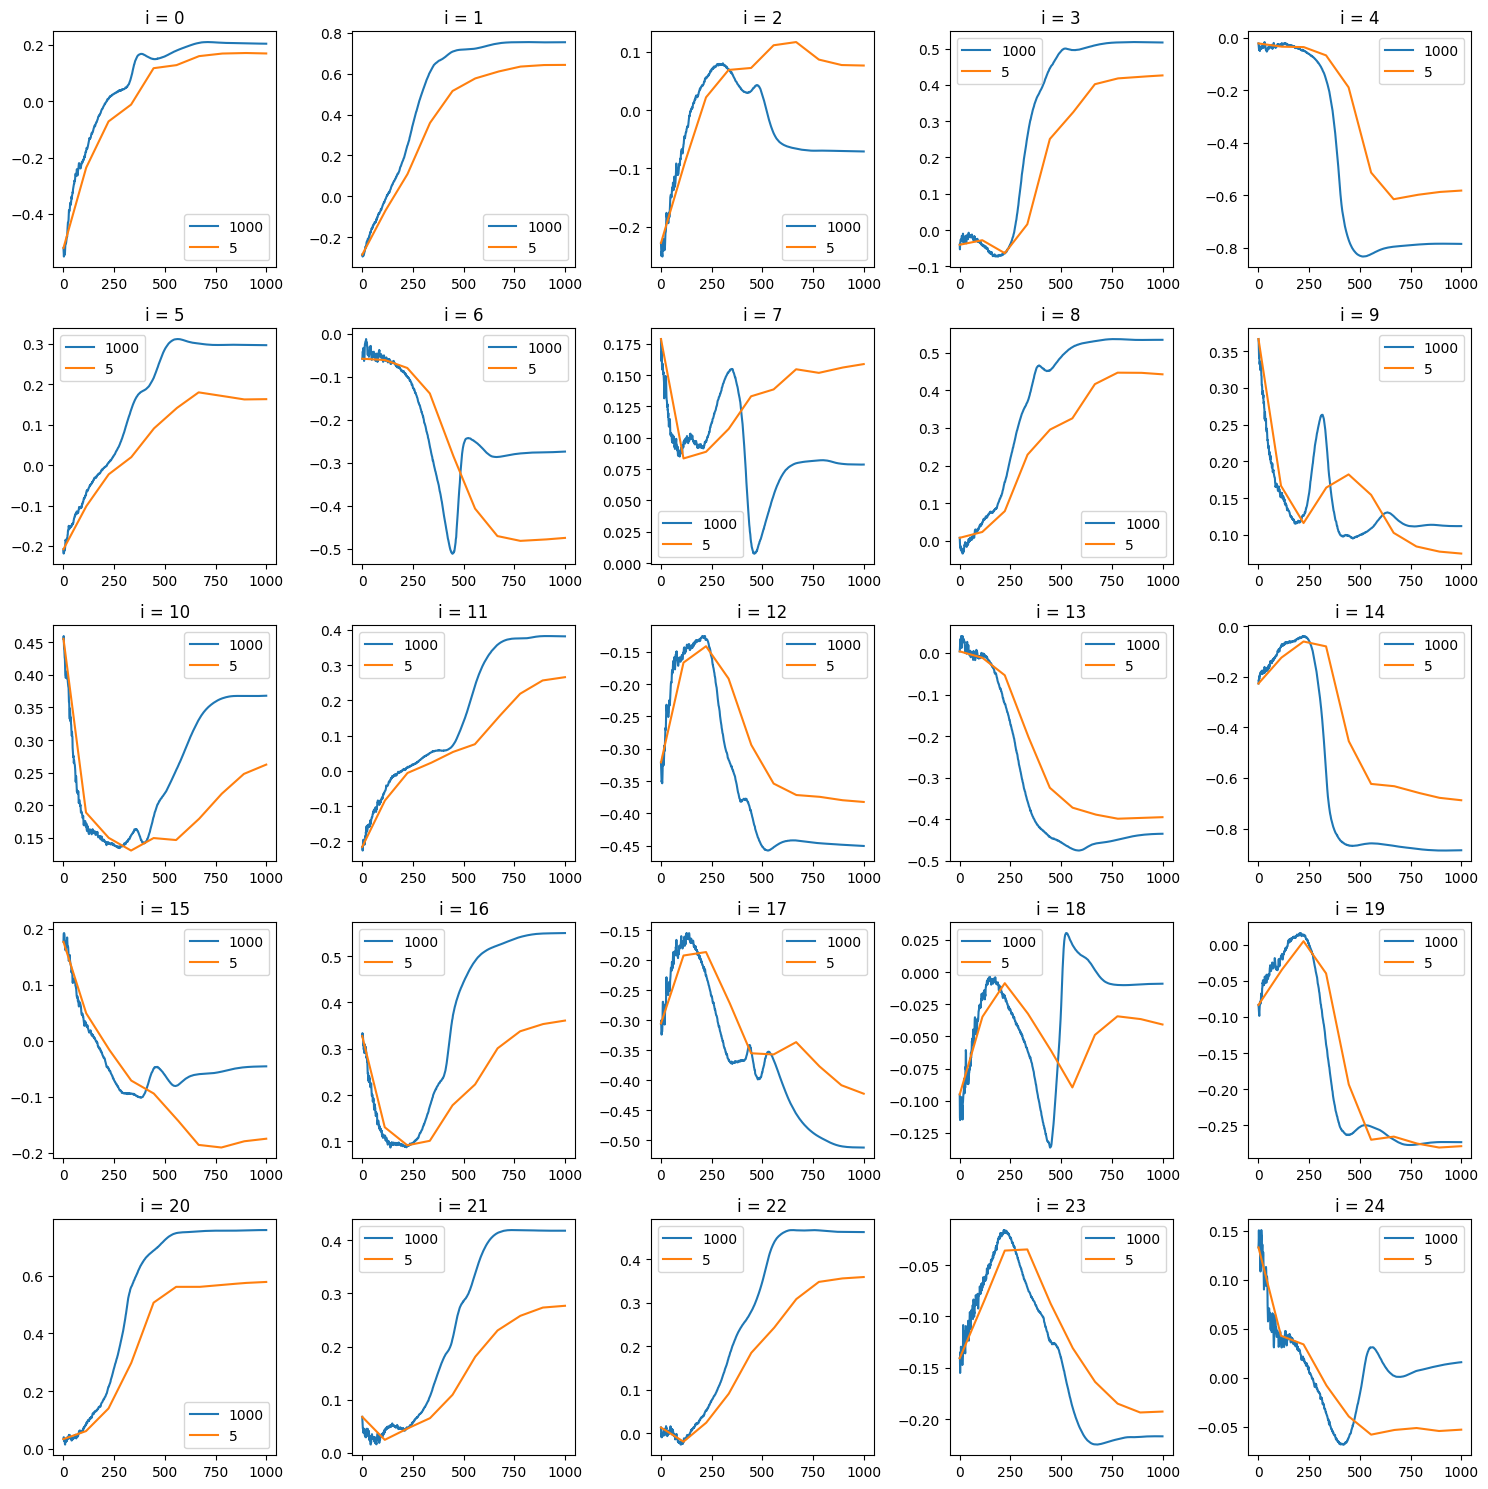

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def interpolate(x, length):
    """
    x      : 1차원 numpy 배열
    length : 반환할 배열의 길이 (정수)
    
    np.interp 함수를 사용하여 원본 x 데이터를 선형 보간하여
    지정한 length 크기의 1차원 배열로 반환합니다.
    """
    # 원본 데이터에 대응하는 x좌표 (0~1 구간으로 생성)
    x_original = np.linspace(0, 1, len(x))
    
    # 보간 후 만들어질 데이터의 x좌표 (0~1 구간으로 length개 생성)
    x_new = np.linspace(0, 1, length)
    
    # 선형 보간
    new_data = np.interp(x_new, x_original, x)
    
    return new_data

# 5x5 서브플롯 생성
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# i = 0부터 24까지 반복
for i in range(25):
    ax = axes[i // 5, i % 5]  # 5x5 그리드에 맞춰 서브플롯 위치 결정
    ax.plot(traj1[i, :, 0], label='1000')
    #ax.plot(interpolate(traj1[i, :, 0], 1000), label='5')
    ax.plot(interpolate(traj3[i, :, 0], 1000), label='5')
    ax.set_title(f'i = {i}')
    ax.legend()

plt.tight_layout()
plt.show()


In [11]:
import math
import torch

def time_linear_interpolate_simple(x: torch.Tensor, t2: int) -> torch.Tensor:
    B, T, C, H, W = x.shape
    
    # 첫 번째 지점: floor(T/t2) - 1 (단, 0 이상으로 보정)
    start_idx = math.floor(T / t2) - 1
    start_idx = max(start_idx, 0)
    
    # 마지막 지점: T - 1
    end_idx = T - 1

    # 위 두 지점을 포함하여 t2개를 선형보간 기준으로 뽑는다
    t_lin = torch.linspace(start_idx, end_idx, steps=t2, device=x.device)
    print(t_lin)
    
    # 아래는 기존 보간 로직과 동일
    floor_idx = t_lin.floor().long()
    alpha = t_lin - floor_idx.float()
    ceil_idx = (floor_idx + 1).clamp(max=T - 1)
    
    x_left = x[:, floor_idx]   # (B, t2, C, H, W)
    x_right = x[:, ceil_idx]   # (B, t2, C, H, W)
    
    alpha = alpha.view(1, t2, 1, 1, 1)
    return x_left * (1 - alpha) + x_right * alpha

x = torch.randn(2, 1000, 3, 32, 32)
x2 = time_linear_interpolate_simple(x, 30)
print(x2.shape)

tensor([ 32.0000,  65.3448,  98.6897, 132.0345, 165.3793, 198.7241, 232.0690,
        265.4138, 298.7586, 332.1034, 365.4482, 398.7931, 432.1379, 465.4827,
        498.8276, 532.1724, 565.5173, 598.8621, 632.2069, 665.5518, 698.8965,
        732.2414, 765.5862, 798.9310, 832.2759, 865.6207, 898.9655, 932.3104,
        965.6552, 999.0000])
torch.Size([2, 30, 3, 32, 32])
